In [50]:
#データの前処理について学びます。
#sample df
import pandas as pd
import numpy as np
df = pd.DataFrame({0:[1,2,3,4],1:[5,6,np.nan,8],2:[10,11,12,np.nan]})
df

,0,1,2
0,1,5.0,10.0
1,2,6.0,11.0
2,3,NaN,12.0
3,4,8.0,NaN


In [51]:
#欠損値にどう対応するか

#まずはdropna
df.dropna(axis=0,how='any')#欠損値がひとつでもふくまれる行はまるごと消す

,0,1,2
0,1,5.0,10.0
1,2,6.0,11.0


In [52]:
#欠損値が一つでもある列は消す
df.dropna(axis=1,how='any')

,0
0,1
1,2
2,3
3,4


In [53]:
#NANのしきい値を指定して削除も可能
df.dropna(axis=0,thresh=2)#NANが2個以上あるある行を消すんだよ

,0,1,2
0,1,5.0,10.0
1,2,6.0,11.0
2,3,NaN,12.0
3,4,8.0,NaN


In [54]:
#NaNを含むからと言って列や行を消してるとデータが少なくなりすぎるのでやめとけ
#代わりに補完をすることがおおい

#sklearnのSimpleImputerで補完
from sklearn.impute import SimpleImputer

#欠損値補完＠平均のインスタンスをつくる
imr = SimpleImputer(missing_values=np.nan,strategy='mean')#列ごとにNANがある場合は、その列の平均値で補完してね？

#データをFITさせて変換もする
df_tr = imr.fit_transform(df)

df_tr

array([[ 1.        ,  5.        , 10.        ],
       [ 2.        ,  6.        , 11.        ],
       [ 3.        ,  6.33333333, 12.        ],
       [ 4.        ,  8.        , 11.        ]])

In [55]:
#カテゴリデータの処理
df2 = pd.DataFrame(
      {'color':['green','red','blue'],
      'size':['M','L','XL'],
      'class':['cl2','cl1','cl0'],
      'price':[10,21,18]}
      )

df2#名義特徴量、順序特徴量、量的特徴量


,color,size,class,price
0,green,M,cl2,10
1,red,L,cl1,21
2,blue,XL,cl0,18


In [56]:
#サイズのような順序特徴量を変換するためには、めいじてきに数値にマッピングしないとだめ
size_mapping = {'XL':3,'L':2,'M':1}

#Tシャツのサイズを数値に変換
df2['size'] = df2['size'].map(size_mapping)

df2

,color,size,class,price
0,green,1,cl2,10
1,red,2,cl1,21
2,blue,3,cl0,18


In [57]:
#クラスラベルのエンコーディング

#mapping用の辞書を作る
class_mapping = {label:idx for idx,label in enumerate(np.unique(df2['class']))}
class_mapping

#mapメソッドで、元のdfのクラスラベルをエンコーディング
df2['class'] = df2['class'].map(class_mapping)
df2#順序特徴量ではなく、名義特徴量であるので、本質的にどのラベルにどの値をふってもよい、という前提に注意せよ

,color,size,class,price
0,green,1,2,10
1,red,2,1,21
2,blue,3,0,18


In [58]:
#sklearnのLabelEncoder使うのが良い
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
yk = LE.fit_transform(df2['class'].values)
yk

array([2, 1, 0], dtype=int64)

In [59]:
#LEをつかってエンコード
X = df2[['color','size','class']].values

#df2のcolor列をラベルエンコードする
X[:,0] = LE.fit_transform(X[:,0])

X

array([[1, 1, 2],
       [2, 2, 1],
       [0, 3, 0]], dtype=object)

In [60]:
#カテゴリデータ（名義尺度）をintにできたがそのままモデルに突っ込んではいけない
#だって色のデータを数値の大小に変換することに意味はないだろう（決定木でやるなら別として）

#これを避けるためには、OneHotEncodingが必要である
from sklearn.preprocessing import OneHotEncoder

Xk = df2[['color','size','class']].values

OE = OneHotEncoder()

OE.fit_transform(Xk[:,0].reshape(-1,1)).toarray()


array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [61]:
#複数の列にOEを適用したい場合はColumnTransformerを使ってみる
from sklearn.compose import ColumnTransformer


Xi = df2[['color','size','class']].values
#ColumnTransformerには、(name,transformer,columns)のタプルのリストを渡す
c_transf = ColumnTransformer([('onehot',OneHotEncoder(),[0]),('nothing','passthrough',[1,2])])#カラムのindiceを指定
#カラム0にだけOEして、残りはなにもしない
#ColumnasTransformer([(名前、変換器、カラムの番号)....])

#そうして作ったColumnTransformerメソッドでfit_transform
X_tf = c_transf.fit_transform(Xi)
X_tf


array([[0.0, 1.0, 0.0, 1, 2],
       [0.0, 0.0, 1.0, 2, 1],
       [1.0, 0.0, 0.0, 3, 0]], dtype=object)

In [62]:
#最も簡単なpd.get_dummies
pd.get_dummies(df2[['color','size','class','price']])#数値文字列は変換されない

#すべてのカテゴリ変数をOEすると、多重共線性に繋がり、Xの逆行列を求められなくなるので、
#OEするときは、drop_first=Trueにしてカラムを一つ減らす
pd.get_dummies(df2[['color','size','class','price']],drop_first=True)#組み合わせの数-1のカラム数でダーミ変数を生成

,size,class,price,color_green,color_red
0,1,2,10,1,0
1,2,1,21,0,1
2,3,0,18,0,0


In [63]:
#OEを使ってエンコード

OHE = OneHotEncoder(categories='auto',drop='first')#カテゴリ特徴量カラムを自動選択、全部の値に対してダミーカラムを作らない

#ColumnTrnasformer使う
CTS = ColumnTransformer([('onehot',OHE,[0]),('nothing','passthrough',[1,2])])

CTS.fit_transform(Xi)

array([[1.0, 0.0, 1, 2],
       [0.0, 1.0, 2, 1],
       [0.0, 0.0, 3, 0]], dtype=object)

In [64]:
#順序特徴量をしきい値でルールベースでエンコーディングする
df3 = pd.DataFrame(
      {'color':['green','red','blue'],
      'size':['M','L','XL'],
      'class':['cl2','cl1','cl0'],
      'price':[10,21,18]}
      )

#LかXLならば1,そうでないなら0というルールベースでのエンコーディングをapply lambdaを使って実装する
df3['X > M'] = df3['size'].apply(lambda x:1 if x in ['L','XL']  else 0)
df3['X > L'] = df3['size'].apply(lambda x:1 if x == 'XL' else 0)

df3

,color,size,class,price,X > M,X > L
0,green,M,cl2,10,0,0
1,red,L,cl1,21,1,0
2,blue,XL,cl0,18,1,1


In [65]:
#Wineデータセットを使ってここまでやったことを実演する
df_wine = pd.read_csv('C:/Users/Administrator/Desktop/Python 3/ML_Master/python-machine-learning-book-3rd-edition/ch04/wine.data',
                     header=None)
df_wine.columns = ['classlabel','alcohol','malic acid','ash','alcalinity of ash','magnesium','ttlphenols','fravanoids',
                  'nf phenols','proatycanin','C-intensity','hue','OD280','Proline']

df_wine

,classlabel,alcohol,malic acid,ash,alcalinity of ash,magnesium,ttlphenols,fravanoids,nf phenols,proatycanin,C-intensity,hue,OD280,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


In [66]:
#L1正則化を実行することで、疎らな解を得たい、実質特徴量選択的なことをしたいとする
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


#のまえに、Xを標準化しておく
SS = StandardScaler()

wine_ss = SS.fit_transform(df_wine.drop('classlabel',axis=1))
X_std = pd.DataFrame(wine_ss)
X_std.columns = df_wine.columns[1:]
X_std

,alcohol,malic acid,ash,alcalinity of ash,magnesium,ttlphenols,fravanoids,nf phenols,proatycanin,C-intensity,hue,OD280,Proline
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,0.876275,2.974543,0.305159,0.301803,-0.332922,-0.985614,-1.424900,1.274310,-0.930179,1.142811,-1.392758,-1.231206,-0.021952
174,0.493343,1.412609,0.414820,1.052516,0.158572,-0.793334,-1.284344,0.549108,-0.316950,0.969783,-1.129518,-1.485445,0.009893
175,0.332758,1.744744,-0.389355,0.151661,1.422412,-1.129824,-1.344582,0.549108,-0.422075,2.224236,-1.612125,-1.485445,0.280575
176,0.209232,0.227694,0.012732,0.151661,1.422412,-1.033684,-1.354622,1.354888,-0.229346,1.834923,-1.568252,-1.400699,0.296498


In [67]:
#分割

y=df_wine['classlabel']

X_train,X_test,y_train,y_test = train_test_split(X_std,y,test_size=0.3,random_state=9)

#L1正則化ロジ
LR1 = LogisticRegression(penalty='l1',C=1.0,random_state=12,solver='liblinear')#lbfgsは、l1正則化非対応なので注意

#Fit
LR1.fit(X_train,y_train)

#訓練データに対する正解率
print('train data accu',LR1.score(X_train,y_train))
print('test data accu',LR1.score(X_test,y_test))

train data accu 1.0
test data accu 1.0


In [68]:
#L1正則化ラッソの、切片を見てみる
print('L1ロジ回帰の切片:',LR1.intercept_)
#3クラスに分類するモデルであり、各クラス分類ごとにモデル(class n vs rest of all)が作られるので、3つの切片がある

#係数は？
print('L1ロジ回数の係数: \n',LR1.coef_)#係数の多くは0になっているので、実質特徴量選択がされたのと同じだよね


L1ロジ回帰の切片: [-1.49944715 -1.00873545 -2.19046562]
L1ロジ回数の係数: 
 [[ 1.46911545  0.26011268  0.71922138 -1.26799796  0.          0.
   0.8181781   0.          0.          0.          0.          0.87070359
   1.97862743]
 [-1.94621935 -0.137884   -1.17834509  0.5812781  -0.13822613  0.
   0.45522207  0.          0.25871214 -1.58015249  1.54503041  0.
  -1.79636233]
 [ 0.          0.          0.53432723  0.          0.          0.
  -2.06791842 -0.0553827   0.          1.96567838 -1.27096048 -0.46936854
   0.        ]]


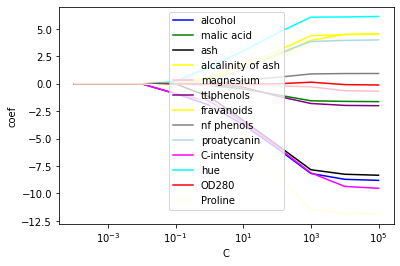

In [69]:
#正則化の程度と、正則化の強さに対する特徴量の重みをプロットする
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)

#各係数の色リスト
cs = ['blue','green','black','yellow','pink','purple','yellow','gray','lightblue','magenta','cyan','red','lightyellow']

#カラリスト(重み係数、正則化パラメタ)
weights,params = [],[]

#逆正則化パラメタの値ごとにまわす
for c in np.arange(-4.,6.,1):
    #10**-4から10**6までのCを試す
    lr = LogisticRegression(C=10.**c,penalty='l1',solver='liblinear',multi_class='ovr',random_state=1)
    #print(10.**c)
    
    lr.fit(X_train,y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)#10のc乗アペンド
    
#重み配列をnumpy配列にする
weights = np.array(weights)

#各重み係数をプロット
for column,color in zip(range(weights.shape[1]),cs):
    #横軸をC、縦軸を重み係数にする
    plt.plot(params,weights[:,column],label=df_wine.columns[column+1],color=color)
plt.ylabel('coef')
plt.xlabel('C')
plt.xscale('log')#横軸は対数スケールにする
plt.legend(loc='lower left')
ax.legend(loc='upper center',ncol=1,fancybox=True)
#ここから見てわかる通り、C（1/λ）を小さくするとramudaが大きくなるので、正則化力が強まり、
#L!正則化だと,10^-1以下でほとんどすべての係数が0になる

In [70]:
#逐次的特徴量削減(SBS)

from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

class SBS:
    """
    逐次後退選択(sbs)を行うクラス
    """
    def __init__(self,estimator,k_features,scoring=accuracy_score,test_size=0.25,
                 random_state=1):
        self.scoring = scoring#特徴量削減した影響を評価する指標
        self.estimator = clone(estimator)#推定機械コピー
        self.k_features = k_features#何個にまで特徴量を減らしたいのか
        self.test_size = test_size#テストデータ比率
        self.random_state = random_state
        
    def fit(self,X,y):
        #train test split
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=self.test_size,random_state=self.random_state)
        #特徴量の個数、列index
        dim = X_train.shape[1]
        #すべての特徴量の個数と、列のindex
        self.indices_ = tuple(range(dim))#特徴量の個数をrangeにしてタプルにして
        self.subsets = [self.indices_]#リストに格納。特徴量を何個使うか、列indexを格納する入れ物
        
        #全特徴量でスコア算出する
        score = self._calc_score(X_train,y_train,X_test,y_test,self.indices_)
        self.scores_ = [score]#全特徴量でのスコアをりすとにぶちこむ
        
        #特徴量が指定個数になるまでくりかえす
        while dim > self.k_features:
            scores = []#スコア初期化
            subsets = []#空の列インデックス
            
            #特徴量の部分集合を表す列indexの組み合わせごとに処理を繰り返す
            for p in combinations(self.indices_, r= dim-1):
                #スコア計算して格納
                score = self._calc_score(X_train,y_train,X_test,y_test,p)
                scores.append(score)
                #特徴量の部分集合を表す列indexのりすとを格納
                subsets.append(p)
                
            #最良のスコアのindexを持ってくる
            best = np.argmax(scores)
            #そのindexに対応した、列indexをもってくる
            self.indices_ = subsets[best]
            self.subsets.append(self.indices_)
            #特徴量の組み合わせの数を1へらす
            dim -= 1
            #スコアを格納
            self.scores_.append(scores[best])
        
        #最後に格納したスコア
        self.k_score_ = self.scores_[-1]
        
        return self
            
    def transform(self,X):
        #抽出した特徴量を返す
        return X[:,self.indices_]
    
    def _calc_score(self,X_train,y_train,X_test,y_test,indices):
        #指定された列番号indicesをextractしてモデル作る
        self.estimator.fit(X_train[:,indices],y_train)
        #テストデータを使ってクラスラベル予測
        y_pred = self.estimator.predict(X_test[:,indices])
        #真のクラスラベルと予測値でスコア算出
        score = self.scoring(y_test,y_pred)
        return score

In [103]:
#13個全ての特徴量を使ってモデルを作る
knn.fit(X_train,y_train)
#訓練データ正解率
print('Train accuracy:',knn.score(X_train,y_train))
#テストデータ正解率
print('Test accuracy:',knn.score(X_test,y_test))

Train accuracy: 0.9758064516129032
Test accuracy: 1.0


In [105]:
#ランダムフォレストで特徴量の重要度を評価する
from sklearn.ensemble import RandomForestClassifier

labels = df_wine.columns[1:]
RFC = RandomForestClassifier(n_estimators=500,random_state=0)
RFC.fit(X_train,y_train)

#特徴量重要度を算出
imp = RFC.feature_importances_
print(imp)


[0.14616227 0.03191475 0.01427738 0.03635549 0.03139879 0.05232035
 0.15161211 0.01087639 0.02601522 0.16261042 0.07728172 0.10797895
 0.15119617]


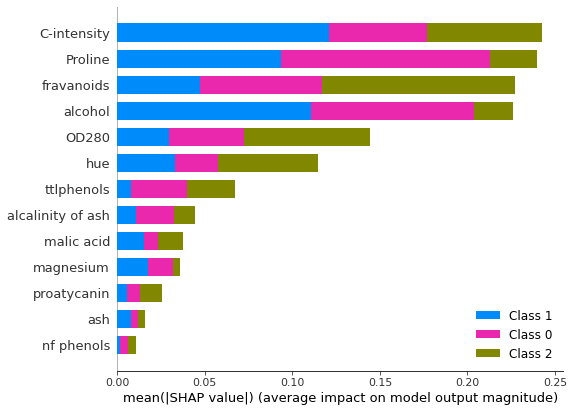

In [106]:
import shap
explainer = shap.TreeExplainer(RFC)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

Text(0, 0.5, 'importances')

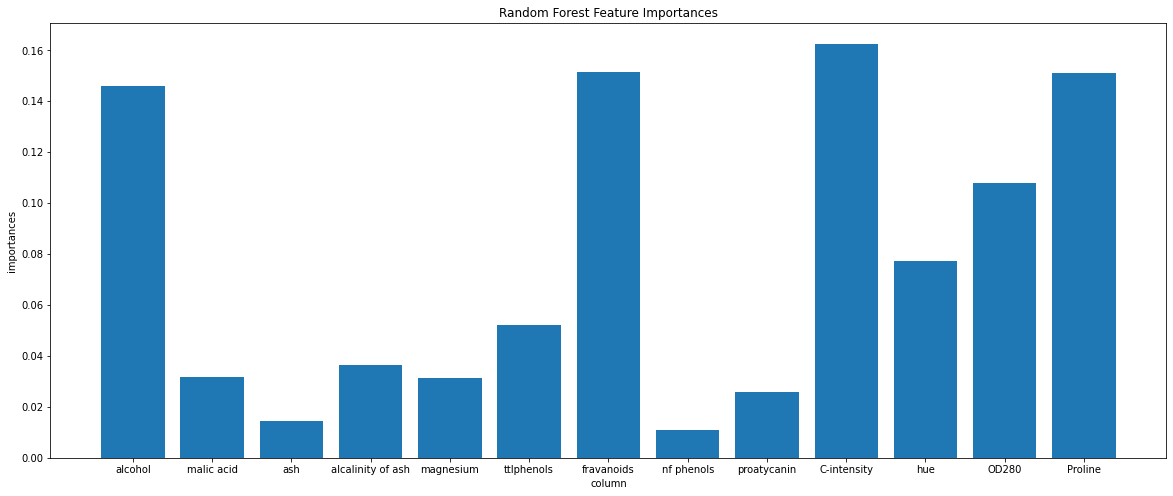

In [107]:
FF = RFC.feature_importances_
plt.figure(figsize=(20,8))
plt.bar(x=df_wine.columns[1:],height=FF)
plt.title('Random Forest Feature Importances')
plt.xlabel('column')
plt.ylabel('importances')

In [108]:
#特徴量の選択には、SelectFromModelを使うことも可能
from sklearn.feature_selection import SelectFromModel

#特徴量選択オブジェクト作成（thresh=0.1）
SFM = SelectFromModel(RFC,threshold=0.1)#SelectFromModel(model,thresh=xx)
#特徴量抽出するためにFit
SFM.fit(X_train,y_train)#train dataにfit

#選択された特徴量(影響度が0.1以上の特徴量)
print(X_train.columns[SFM.get_support()])#SFM.get_support()でXデータの各カラムのboolで出力（thresh以上のカラムがTrue）

Index(['alcohol', 'fravanoids', 'C-intensity', 'OD280', 'Proline'], dtype='object')
